In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import nrrd
import seaborn as sns
from typing import List
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# I/O

# Data directory
data = os.path.abspath('./data')

# 1. Data loading

## 1.1. Getting list of DICOM files from folder

In [3]:
# Retrieving dcm filenames from data folder 

def dicom_list(data_dir: str) -> List[str]: 
    '''Locate all .dcm files in directory'''
    dicoms = []
    for dirs, subdirs, filenames in os.walk(data_dir):
        
        for filename in filenames:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                dicoms.append(os.path.join(data_dir, filename))
    
    return sorted(dicoms)

In [4]:
dcms = dicom_list(data)

In [5]:
# Length of our dataset
len(dcms)

140

## 1.2. Loading DICOMs as `np.ndarray`

In [6]:
def dcm_as_np(dicom_list: List[str]) -> np.ndarray:
    
    ref_dcm = pydicom.read_file(dicom_list[0])

    # Load dimensions based on the number of rows & columns
    dims = (len(dicom_list), int(ref_dcm.Rows), int(ref_dcm.Columns))
    
    dcm_array = np.zeros(dims, dtype=ref_dcm.pixel_array.dtype)
    
    for filename in dicom_list:
        # read the file
        ds = pydicom.read_file(filename)
        # store the raw image data
        dcm_array[ dicom_list.index(filename), :, :] = ds.pixel_array
    
    return dcm_array

In [7]:
dcm_array = dcm_as_np(dcms)

In [8]:
type(dcm_array)

numpy.ndarray

In [9]:
dcm_array = dcm_array[:, :, :, np.newaxis]

In [10]:
dcm_array.shape

(140, 512, 512, 1)

## 1.3. Loading `nrrd` masks

In [11]:
def nrrd_list(data_dir: str, region: str) -> List[str]:
    '''Locate referenced .nrrd files in directory'''
    nrrd_list = []
    for dirs, subdirs, filenames in os.walk(data_dir):
        
        for filename in filenames:
            if region in filename.lower():  # check whether the file's DICOM
                nrrd_list.append(os.path.join(data_dir, filename))
    
    return sorted(nrrd_list)

def load_nrrd(nrrd_list: List[str]) -> np.ndarray:
    
    ref_nrrd, header = nrrd.read(nrrd_list[0])

    # Load dimensions based on the number of rows & columns
    dims = (len(nrrd_list), ref_nrrd.shape[0], ref_nrrd.shape[1])
    nrrd_array = np.zeros(dims)
    
    for filename in nrrd_list:
        data, header = nrrd.read(filename)
        nrrd_array[nrrd_list.index(filename), :, :] = data.T
    
    return nrrd_array

In [12]:
mask={}

In [13]:
region_0 = load_nrrd(nrrd_list(data, 'region 0'))

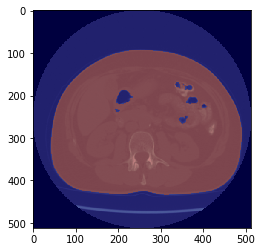

In [14]:
plt.imshow(dcm_array[0, :, :], cmap=plt.cm.bone, interpolation='nearest')
plt.imshow(region_0[0, :, :], cmap='jet', alpha=0.5, interpolation='nearest');

To get **background mask** we need to **invert region 0** - *all tissues* mask

In [15]:
# loading all masks
background = np.logical_not(load_nrrd(nrrd_list(data, 'region 0')))
subcutaneous_fat_mask = load_nrrd(nrrd_list(data, 'region 1'))
intramuscular_fat_mask = load_nrrd(nrrd_list(data, 'region 2'))
skeletal_muscle_mask = load_nrrd(nrrd_list(data, 'region 3'))
visceral_fat_mask = load_nrrd(nrrd_list(data, 'region 4'))

# 2. Data preprocessing
## 2.1. Normalization

In [16]:
def mean_normalize(x: np.array) -> np.array:
    '''Mean normalization for array'''
    return (x - np.mean(x)) / np.std(x)

def min_max(x: np.array) -> np.array:
    '''Min max normalization for array'''
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [17]:
dcm_norm, dcm_min_max = mean_normalize(dcm_array), min_max(dcm_array)

In [18]:
dcm_norm.shape

(140, 512, 512, 1)

## 2.2. Image augmenation 

In [19]:
# create image data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [20]:
it = datagen.flow(dcm_norm, batch_size=1)

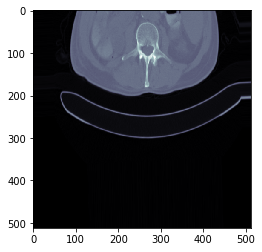

In [34]:
batch = it.next()
plt.imshow(batch[0, :, :], cmap=plt.cm.bone, interpolation='nearest')